## M1 popularity

On fold 1 some first exploratory experiments with PCA are performed.
Evaluation: https://vitalflux.com/interpreting-f-statistics-in-linear-regression-formula-examples
The general conclusion is that PCA is not improving results: a simple regression with all features gives the best result.

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from scipy import stats 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly.express as px

sns.set_theme()

In [3]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

    def first(self):
        select = self.fts.copy()
        select = select.loc[select['n']=='01']
        return self.format(select)

    def mfcc(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='mfcc']
        return self.format(select)

    def tonnetz(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='tonnetz']
        return self.format(select)

    def min(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='min']
        return self.format(select)
    
    def max(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='max']
        return self.format(select)

    def median(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='median']
        return self.format(select)

    def mean(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='mean']
        return self.format(select)
    
    def std(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='std']
        return self.format(select)

    def skew(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='skew']
        return self.format(select)

    def kurtosis(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='kurtosis']
        return self.format(select)

    def per_nns(self):
        """
        List of lists per name1, name2, stat, per name1, name2.
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['stat'], sort=False)] for idx, grp in select.groupby(by=['name1', 'name2'])]
        return select
    
    def per_sn(self):
        """
        List of lists per stat, n. 
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['n'], sort=False)] for idx, grp in select.groupby(by=['stat'], sort=False)]
        return select

fts = Feats('features.csv')

In [4]:
# Read data
df = pd.read_csv('data/fold/f1_train.csv',  parse_dates=['release'])
df = df.drop(columns=['release'])

#### Preprocessing

In [5]:
n_orig = df.shape[0]

# Drop na values
n_na = df['popularity'].isna().sum()
df = df.dropna(subset=['popularity'])

# Drop zero values
n_zero =df.loc[df['popularity']==0].shape[0]
df = df.loc[df['popularity']>0]

print(f'm1: Dropped {n_na} na entries and {n_zero} zero entries of {n_orig}, {df.shape[0]} entries left.')

m1: Dropped 0 na entries and 1 zero entries of 68207, 68206 entries left.


In [6]:
y_before = df['popularity']
y = stats.boxcox(y_before)[0]

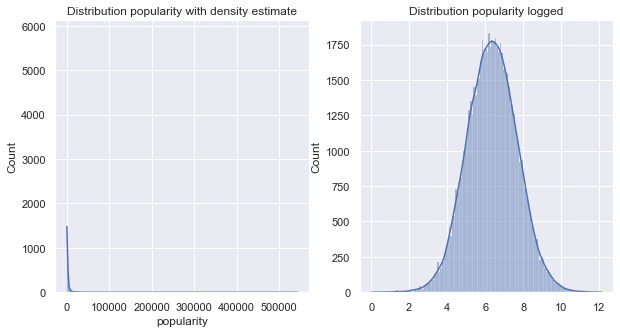

In [6]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(x=y_before, kde=True, ax=axs[0])
ax1.set(title="Distribution popularity with density estimate")

ax2 = sns.histplot(x=y, kde=True, ax=axs[1])
ax2.set(title="Distribution popularity logged")

fig;

In [7]:
# Feature scaling
# Looking at distributions, some features appear to already have been scaled, in a minmax 0 - 1 normalization.
# https://www.atoti.io/articles/when-to-perform-a-feature-scaling/
# So, the features that are not scaled from -1 to 1, will be scaled.

X = df.drop(columns=['popularity'])

scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X = pd.DataFrame(X, columns=fts.all())

In [7]:
X.mean()

chroma_cens_min_01   -3.229456e-18
chroma_cens_min_02   -1.458464e-18
chroma_cens_min_03    3.125280e-18
chroma_cens_min_04   -1.406376e-18
chroma_cens_min_05   -2.500224e-18
                          ...     
zcr_median_01         7.729858e-17
zcr_mean_01           9.818587e-17
zcr_std_01            4.625414e-17
zcr_skew_01           1.089160e-16
zcr_kurtosis_01      -8.354914e-17
Length: 518, dtype: float64

In [9]:
X.std()

chroma_cens_min_01    1.000007
chroma_cens_min_02    1.000007
chroma_cens_min_03    1.000007
chroma_cens_min_04    1.000007
chroma_cens_min_05    1.000007
                        ...   
zcr_median_01         1.000007
zcr_mean_01           1.000007
zcr_std_01            1.000007
zcr_skew_01           1.000007
zcr_kurtosis_01       1.000007
Length: 518, dtype: float64

### Experiments

In [ ]:
# Data is not linear...

In [10]:
# Rank feats in terms of correlation with target
# This doesnt change with or without box cox
corrs = [(column, pearsonr(X[column], y)[0]) for column in X]
corrs = sorted(corrs, key=lambda x: x[1], reverse=True)
for cor in corrs:
    print(f'{cor[0]}: {cor[1]}')

spectral_contrast_mean_03: 0.21279950400010084
spectral_contrast_median_03: 0.21115536429410767
spectral_contrast_mean_02: 0.1903571418034701
spectral_contrast_median_02: 0.18895114124381182
tonnetz_kurtosis_03: 0.17807638982996443
tonnetz_kurtosis_04: 0.17656942227273392
spectral_contrast_median_04: 0.17625445004931484
spectral_contrast_mean_04: 0.17524842840064242
chroma_cens_kurtosis_03: 0.14962254672103203
chroma_cens_kurtosis_08: 0.1494939748748515
chroma_cens_kurtosis_10: 0.14860260519931706
chroma_cens_kurtosis_06: 0.14837867133262303
chroma_cens_kurtosis_01: 0.14530694939508199
mfcc_median_03: 0.1410748079308608
mfcc_mean_03: 0.13806624362471487
chroma_cens_kurtosis_05: 0.13589317977165688
chroma_cens_kurtosis_07: 0.13506698052041738
spectral_contrast_max_03: 0.1344272025343701
tonnetz_kurtosis_05: 0.13067791690799932
chroma_cens_kurtosis_04: 0.12955453813076967
spectral_contrast_kurtosis_04: 0.12862289098185054
chroma_cens_kurtosis_12: 0.1281503222910245
chroma_cens_kurtosis_0

In [82]:
# Take 5 most correlative functions and fit a regression

X_select = X[['spectral_contrast_mean_03', 'spectral_contrast_median_03', 'spectral_contrast_mean_02', 'spectral_contrast_median_02', 'tonnetz_kurtosis_03']]

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))

0.051566704511695205


In [68]:
print(model.coef_)
print(model.intercept_)

[ 0.21449001 -0.01226263  0.24608782 -0.2278067   0.1170238 ]
6.364520127007535


ValueError: regplot inputs must be 1d

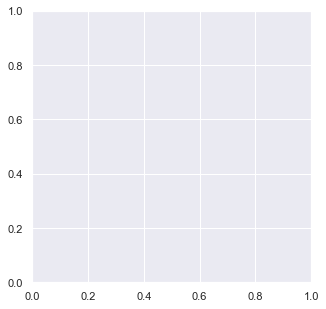

In [66]:
fig, axs = plt.subplots(figsize=(5,5))

x = X['spectral_contrast_mean_03']
y 

fig = sns.regplot(x=X_select, y=y, order=1)
fig.set_xlim(-3, 13)
fig.set_ylim(-3, 13)

fig;

In [ ]:
# Pairwise mutual information



### Simple linear PCA experiments

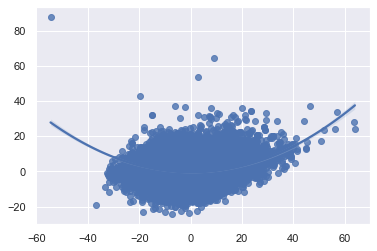

In [8]:
# Fit a PCA and rank most significant components

pca = PCA(n_components=2)
pca.fit(X)

components = pca.transform(X)
components = components.T

sns.regplot(x=components[0], y=components[1], order=2);

In [ ]:
import plotly.express as px

bins = [0, 10, 100, 1000, 10000, 100000, 1000000]
labels = ["1s", "10s", "100s", "1000s", "10.000s", "100.000s"]

df['popularity_bins'] = pd.cut(df['popularity'], bins=bins, labels=labels, right=False)
df['popularity_bins'] = df['popularity_bins'].cat.add_categories('unknown').fillna('unknown')

pca = PCA(n_components=2)
components = pca.fit_transform(df[fts.all()])

fig = px.scatter(components, x=0, y=1, color=df['popularity_bins'])
fig.show()

# Is the color right??

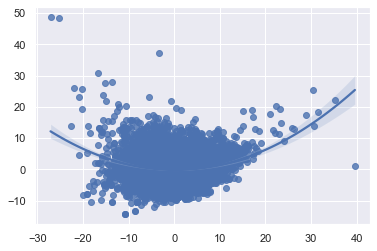

In [14]:
pca = PCA(n_components=2)
pca.fit(X[fts.first()])

components = pca.transform(X[fts.first()])
components = components.T

sns.regplot(x=components[0], y=components[1], order=2);

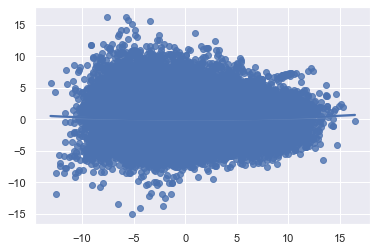

In [15]:
pca = PCA(n_components=2)
pca.fit(X[fts.mean()])

components = pca.transform(X[fts.mean()])
components = components.T

sns.regplot(x=components[0], y=components[1], order=2);

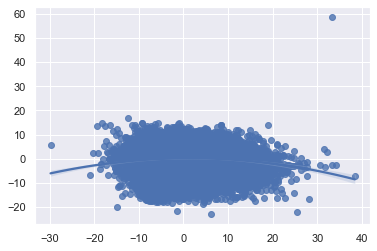

In [17]:
pca = PCA(n_components=2)
pca.fit(X[fts.mfcc()])

components = pca.transform(X[fts.mfcc()])
components = components.T

sns.regplot(x=components[0], y=components[1], order=2);

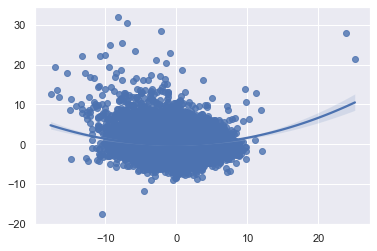

In [18]:
pca = PCA(n_components=2)
pca.fit(X[fts.tonnetz()])

components = pca.transform(X[fts.tonnetz()])
components = components.T

sns.regplot(x=components[0], y=components[1], order=2);

### PCA experiments with polynomial kernel

(13641, 77)


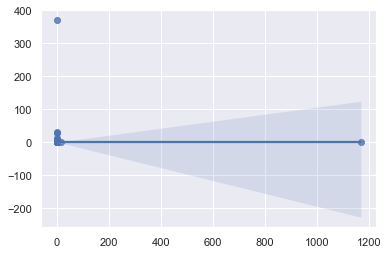

In [29]:
X_frac = X[fts.first()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=1);


(13641, 518)


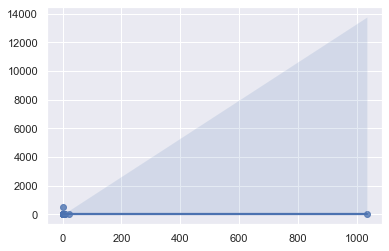

In [54]:
X_frac = X[fts.all()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=1);


(13641, 140)


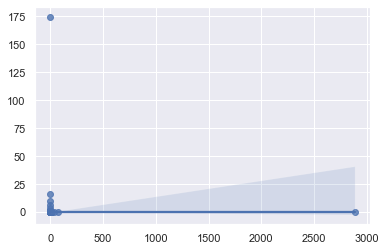

In [30]:
X_frac = X[fts.mfcc()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=1);


(13641, 42)


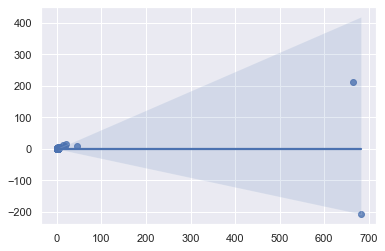

In [31]:
X_frac = X[fts.tonnetz()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=1);


(13641, 74)


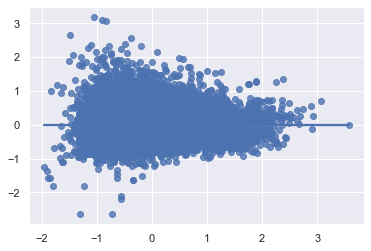

In [33]:
X_frac = X[fts.mean()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=1);


(13641, 74)


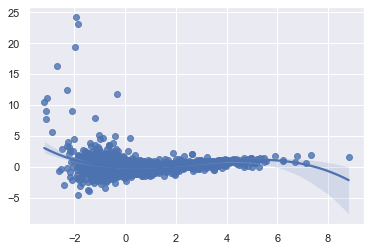

In [36]:
X_frac = X[fts.mean()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=3, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=2);


(13641, 74)


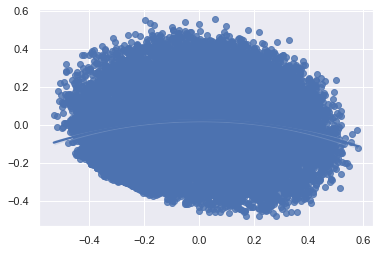

In [47]:
X_frac = X[fts.mean()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='rbf', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=2);


(13641, 74)


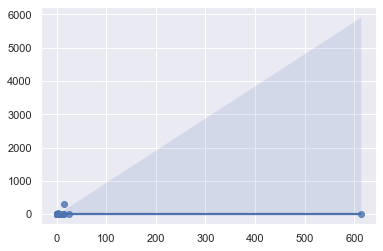

In [37]:
X_frac = X[fts.skew()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X_frac)
components = components.T

sns.regplot(x=components[0], y=components[1], order=1);


(13641, 42)


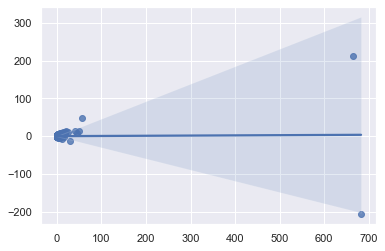

In [32]:
X_frac = X[fts.tonnetz()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=2, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X[fts.tonnetz()])
components = components.T

sns.regplot(x=components[0], y=components[1], order=1);


In [95]:
print(len(fts.mean()))

74


In [106]:
pca = PCA(n_components=70)
pca.fit(X[fts.first()])

components = pca.transform(X[fts.first()])
# components = components.T

# sns.regplot(x=components[0], y=components[1], order=2);

X_select = components

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))

0.06574415152531599


In [96]:
pca = PCA(n_components=70)
pca.fit(X[fts.mean()])

components = pca.transform(X[fts.mean()])
# components = components.T

# sns.regplot(x=components[0], y=components[1], order=2);

X_select = components

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))

0.08155479367249374


In [102]:
pca = PCA(n_components=150)
pca.fit(X[fts.all()])

components = pca.transform(X[fts.all()])
# components = components.T

# sns.regplot(x=components[0], y=components[1], order=2);

X_select = components

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))

0.10546416374244816


In [98]:
X_select = X[fts.all()]

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))

0.1374642090606082


(13641, 74)


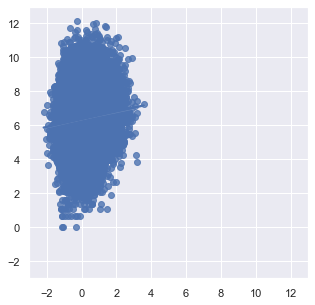

In [70]:
X_frac = X[fts.mean()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=1, degree=2, random_state=0)
pca.fit(X_frac)

components = pca.transform(X[fts.mean()])
components = components.T

fig, axs = plt.subplots(figsize=(5,5))

fig = sns.regplot(x=components, y=y, order=1)
fig.set_xlim(-3, 13)
fig.set_ylim(-3, 13)

fig;


In [81]:
X_select = components[0].reshape(-1, 1)

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))

0.012912522873492538


In [88]:
X_frac = X[fts.mean()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=5, degree=3, random_state=0)
pca.fit(X_frac)

components = pca.transform(X[fts.mean()])
# components = components.T

# fig, axs = plt.subplots(figsize=(5,5))

# fig = sns.regplot(x=components, y=y, order=1)
# fig.set_xlim(-3, 13)
# fig.set_ylim(-3, 13)

# fig;


(13641, 74)


In [89]:
X_select = components

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))

0.0219178348222544


In [107]:
X_frac = X[fts.mean()].sample(frac=0.2, random_state=0)
print(X_frac.shape)

# Since fitting is the problem, would it work to fit on a sample and transform the whole set?

pca = KernelPCA(kernel='poly', n_components=50, degree=3, random_state=0)
pca.fit(X_frac)

components = pca.transform(X[fts.mean()])

model = LinearRegression().fit(X_select, y)
print(model.score(X_select, y))


(13641, 74)
0.06574415152531599


### Truncated SVD

In [ ]:
# Truncated SVD

In [ ]:
# Tsne / Umap/isomap
# https://stats.stackexchange.com/questions/402668/intuitive-explanation-of-how-umap-works-compared-to-t-sne

In [ ]:
# Kmeans?

#### Outliers
There seem to be some extreme outliers that distort the dimensionality reduction.